Проверка стационарности данных...
ADF Statistic: -8.5988
p-value: 0.0000
Ряд стационарный, дифференцирование не требуется (d=0)

Используемые параметры ARIMA: p=2, d=0, q=1


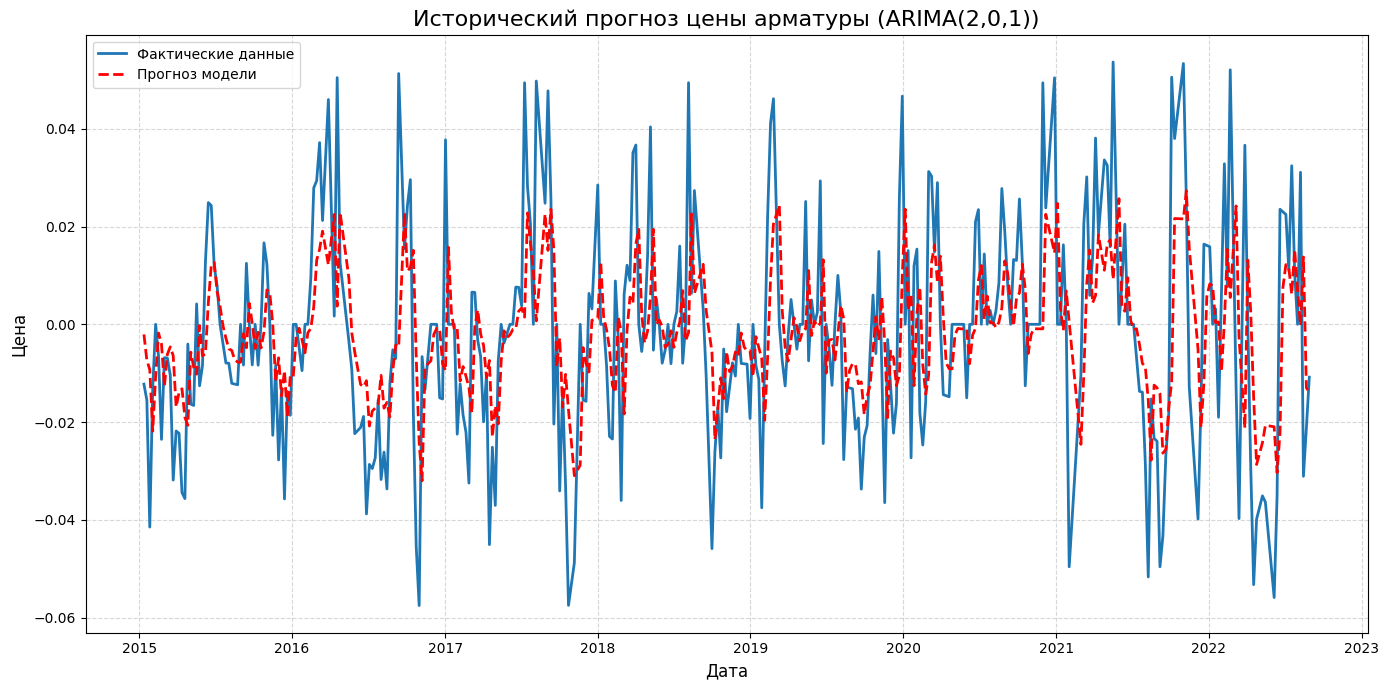


Метрики качества модели:
Среднеквадратичная ошибка (RMSE): 0.0188
Средняя абсолютная ошибка (MAE): 0.0140
Средняя абсолютная процентная ошибка (MAPE): 0.00%

Тест Льюнга-Бокса (p-value): 0.4866
Остатки не имеют значимой автокорреляции (хорошо)


In [4]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

def создать_модель_arima_и_вывести_прогноз(путь_к_файлу, имя_столбца_цены):
    """
    Функция прогнозирования с ручным подбором параметров ARIMA,
    выводом исторического прогноза и проверкой остатков.
    Без метрики R², как было запрошено.
    """
    try:
        # 1. Загрузка и подготовка данных
        df = pd.read_csv(путь_к_файлу, parse_dates=['Date'])
        df = df.sort_values(by='Date').set_index('Date')
        
        if имя_столбца_цены not in df.columns:
            raise KeyError(f"Столбец '{имя_столбца_цены}' не найден.")
            
        series = df[имя_столбца_цены].dropna()
        
        # 2. Проверка на стационарность и определение порядка дифференцирования
        print("Проверка стационарности данных...")
        adf_result = adfuller(series)
        print(f'ADF Statistic: {adf_result[0]:.4f}')
        print(f'p-value: {adf_result[1]:.4f}')
        
        # Если ряд не стационарный, применяем дифференцирование
        d = 0
        if adf_result[1] > 0.05:
            d = 1
            series_diff = series.diff().dropna()
            print("Ряд не стационарный, применяем дифференцирование (d=1)")
        else:
            print("Ряд стационарный, дифференцирование не требуется (d=0)")
        
        # 3. Подбор параметров ARIMA (p,d,q)
        p = 2  # Авторегрессионная часть
        q = 1  # Скользящее среднее
        print(f"\nИспользуемые параметры ARIMA: p={p}, d={d}, q={q}")
        
        # 4. Обучение модели
        arima_model = ARIMA(series, order=(p, d, q))
        model_fit = arima_model.fit()
        
        # 5. Прогнозирование для исторического периода
        historical_forecast = model_fit.predict(start=series.index[0], end=series.index[-1])
        
        # 6. Визуализация
        plt.figure(figsize=(14, 7))
        
        # Фактические данные
        plt.plot(series.index, series, label='Фактические данные', 
                color='#1f77b4', linewidth=2)
        
        # Прогноз для исторического периода
        plt.plot(historical_forecast.index, historical_forecast, 
                label='Прогноз модели', color='#FF0000', 
                linestyle='--', linewidth=2)
        
        # Настройки графика
        plt.title(f'Исторический прогноз цены арматуры (ARIMA({p},{d},{q}))', fontsize=16)
        plt.xlabel('Дата', fontsize=12)
        plt.ylabel('Цена', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
        
        # 7. Расчет и вывод метрик (без R²)
        mse = mean_squared_error(series, historical_forecast)
        mae = mean_absolute_error(series, historical_forecast)
        rmse = np.sqrt(mse)
        
        print("\nМетрики качества модели:")
        print(f"Среднеквадратичная ошибка (RMSE): {rmse:.4f}")
        print(f"Средняя абсолютная ошибка (MAE): {mae:.4f}")
        
        # Расчет MAPE (с обработкой деления на ноль)
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((series - historical_forecast) / series)) * 100
            mape = np.nan_to_num(mape, nan=0.0, posinf=0.0, neginf=0.0)
        print(f"Средняя абсолютная процентная ошибка (MAPE): {mape:.2f}%")
        
        # 8. Тест Льюнга-Бокса на автокорреляцию остатков
        residuals = series - historical_forecast
        lb_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
        lb_pvalue = lb_test['lb_pvalue'].values[0]
        print(f"\nТест Льюнга-Бокса (p-value): {lb_pvalue:.4f}")
        
        if lb_pvalue > 0.05:
            print("Остатки не имеют значимой автокорреляции (хорошо)")
        else:
            print("Остатки имеют автокорреляцию (плохо)")
    
    except Exception as e:
        print(f"Произошла ошибка: {str(e)}")

# Пример использования
путь_к_файлу = 'C:\\Users\\Karina\\Desktop\\Новая папка\\cleaned_stationary_data.csv'
имя_столбца_цены = 'Цена на арматуру_x_stationary'
создать_модель_arima_и_вывести_прогноз(путь_к_файлу, имя_столбца_цены)

ADF Statistic: -8.598756318151056
p-value: 6.961059677353384e-14
Critical Values: {'1%': np.float64(-3.4483935212959844), '5%': np.float64(-2.8694912343676497), '10%': np.float64(-2.571005879151811)}


c:\Users\Karina\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Karina\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Karina\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Karina\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood opti

Оценка качества модели на исторических данных:
RMSE: 0.03
MAE: 0.02


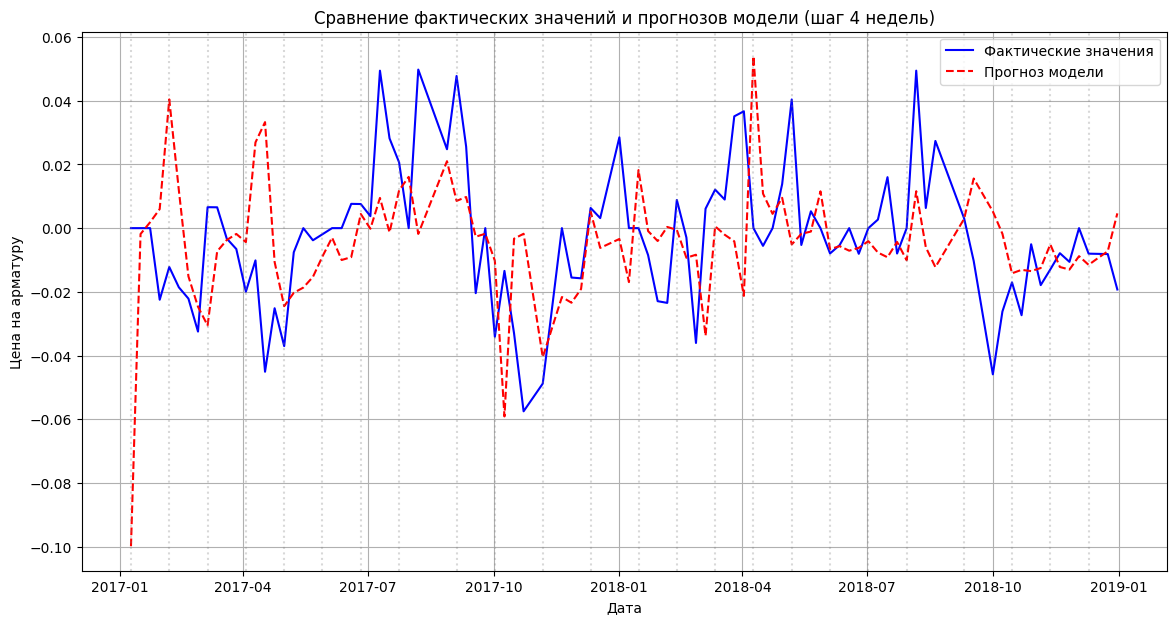


Первые несколько прогнозов:
              Actual  Forecast
Date                          
2017-01-09  0.000000 -0.099827
2017-01-16  0.000000 -0.001839
2017-01-23  0.000000  0.001859
2017-01-30 -0.022473  0.005987
2017-02-06 -0.012195  0.040402
2017-02-13 -0.018576  0.011881
2017-02-20 -0.022118 -0.015142
2017-02-27 -0.032470 -0.024672
2017-03-06  0.006579 -0.030528
2017-03-13  0.006536 -0.007289


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt

# Загрузка данных
data = pd.read_csv('C:\\Users\\Karina\\Desktop\\Новая папка\\Обработанные данные.csv', parse_dates=['Date'], index_col='Date')

# Целевая переменная
y = data['Цена на арматуру_x_stationary']

# Экзогенные переменные (исключаем целевую и дату)
exog = data.drop('Цена на арматуру_x_stationary', axis=1)

# Проверка стационарности
def check_stationarity(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

check_stationarity(y)  # Убедимся, что ряд стационарный

# Подбор параметров ARIMA (p,d,q)
p, d, q = 1, 0, 1  # примерные параметры

# Функция для прогноза на исторические данные с визуализацией (оптимизированная)
def historical_forecast_with_plot(start_date, end_date, N_weeks, step=1):
    """
    start_date: начальная дата для прогноза
    end_date: конечная дата для прогноза
    N_weeks: количество недель для каждого прогноза
    step: шаг между прогнозами (увеличиваем для ускорения)
    """
    # Выбираем диапазон данных для анализа
    history = y[start_date:end_date]
    exog_history = exog[start_date:end_date]
    
    # Создаем списки для хранения результатов
    forecasts = []
    actuals = []
    dates = []
    
    # Делаем "скользящий" прогноз на N недель вперед с заданным шагом
    for i in range(0, len(history) - N_weeks, step):
        current_date = history.index[i]
        
        # Данные для обучения модели (берем все данные до текущей даты)
        train_data = y[:current_date]
        exog_train_data = exog[:current_date]
        
        try:
            # Обучаем модель с suppress_warnings=True для уменьшения вывода
            model = ARIMA(train_data, exog=exog_train_data, order=(p,d,q))
            model_fit = model.fit()
            
            # Данные для прогноза
            forecast_dates = history.index[i+1:i+1+N_weeks]
            exog_forecast_data = exog.loc[forecast_dates]
            
            # Прогнозируем
            forecast = model_fit.forecast(steps=N_weeks, exog=exog_forecast_data)
            
            # Сохраняем результаты
            forecasts.extend(forecast)
            actuals.extend(history.iloc[i+1:i+1+N_weeks])
            dates.extend(forecast_dates)
        except:
            # Пропускаем итерации, где модель не сходится
            continue
    
    # Создаем DataFrame с результатами
    results = pd.DataFrame({
        'Date': dates,
        'Actual': actuals,
        'Forecast': forecasts
    }).set_index('Date')
    
    # Рассчитываем ошибки
    if len(results) > 0:
        mse = mean_squared_error(results['Actual'], results['Forecast'])
        rmse = sqrt(mse)
        mae = np.mean(np.abs(results['Actual'] - results['Forecast']))
        
        print(f"Оценка качества модели на исторических данных:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
    else:
        print("Не удалось получить прогнозы. Попробуйте изменить параметры.")
        return None
    
    # Визуализация
    plt.figure(figsize=(14, 7))
    plt.plot(results.index, results['Actual'], label='Фактические значения', color='blue')
    plt.plot(results.index, results['Forecast'], label='Прогноз модели', color='red', linestyle='--')
    
    # Добавляем вертикальные линии для каждого прогноза
    for i in range(0, len(results), N_weeks):
        plt.axvline(x=results.index[i], color='gray', linestyle=':', alpha=0.3)
    
    plt.title(f'Сравнение фактических значений и прогнозов модели (шаг {N_weeks} недель)')
    plt.xlabel('Дата')
    plt.ylabel('Цена на арматуру')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return results

# Пример использования для исторического прогноза с увеличенным шагом
start_date = '2017-01-01'
end_date = '2018-12-31'
N_weeks = 4
step = 4  # Увеличиваем шаг между прогнозами в 4 раза для ускорения

historical_results = historical_forecast_with_plot(start_date, end_date, N_weeks, step)

# Дополнительно: можно посмотреть первые несколько прогнозов
if historical_results is not None:
    print("\nПервые несколько прогнозов:")
    print(historical_results.head(10))